In [3]:
# in this notebook I will develop a vanilla version of FEA using only basic python functions
# Based on PolymerFEM: https://youtu.be/1j_HdsVkglk
# Description: linear finite element analysis for 2D plane strain for linear elastic materials
# Units: mm

import numpy as np
from matplotlib import pyplot as plt

In [95]:
# defining helper ftions

# converting 'natural' coordinates xi, eta into shape functions: (n1, n2, n3, n4)
def shape(xi,eta):
    N1 = (1 - xi) * (1 - eta)
    N2 = (1 + xi) * (1 - eta)
    N3 = (1 + xi) * (1 + eta)
    N4 = (1 - xi) * (1 + eta)
    Ns = np.array([N1, N2, N3, N4])
    return 0.25 * Ns

# 'natural' coordinates xi, eta into gradients of the shape ftions: [(dn1/dx, dn2/dx, ...),
#                                                                    (dn1/de, dn2/de,...)]
def grad_shape(xi, eta):
    dN = np.array([[-1 * (1-eta), 1 * (1-eta), 1 * (1+eta), -1 * (1+eta)],
                   [-1 * (1-xi), -1 * (1+xi), 1 * (1+xi), 1 * (1-xi)]])
    return 0.25 * dN

# plotting mesh - function call:    plot_mesh(nodes, conn, plot_connections=True)
def plot_mesh(nodes, conn, plot_connections=True):
    plt.figure(figsize=(12,12))
    plt.grid(color = 'gray', linewidth=0.2)

    if plot_connections:  # plotting connections
        connections = set()
        for el in conn:
            if len(el) == 4:
                c1, c2, c3, c4 = (el[0], el[1]), (el[1], el[2]), (el[2], el[3]), (el[3], el[0])
                connections.add(c1); connections.add(c2); connections.add(c3); connections.add(c4)
            elif len(el) == 3:
                c1, c2, c3 = (el[0], el[1]), (el[1], el[2]), (el[2], el[0])
                connections.add(c1); connections.add(c2); connections.add(c3)
        for (el1, el2) in connections:
            (x1, y1) = nodes[el1]
            (x2, y2) = nodes[el2]
            plt.plot([x1, x2], [y1, y2], linewidth=0.9, color='orange', marker='', zorder=1)

    plt.scatter(nodes[:,0], nodes[:,1], marker='o', color='b', s=5, zorder=2)  # plot nodes
    plt.axis('equal')
    plt.show()

In [32]:
# defining a mesh -> list of coordinates for each node
#                 -> list of connections between nodes ('connectivity'/adjacency)

# for a rectancgular block of (num_el_x, num_el_y) elements and dimensions (l_x, l_y)
num_el_x, num_el_y = 9, 49   # num of elements
l_x, l_y = 10, 50            # dimensions in x,y
num_nx = num_el_x + 1        # num of nodes in x
num_ny = num_el_y + 1        # num of nodes in y

num_nodes = num_nx * num_ny
num_elements = num_el_x * num_el_y
hx = l_x / num_el_x
hy = l_y / num_el_y

nodes = []  # list of coordinates of all nodes
for y in np.linspace(0., l_y, num_ny):
    for x in np.linspace(0,l_x, num_nx):
        nodes.append([x,y])
nodes = np.array(nodes)

conn = []  # list of connections for each element
for j in range(num_el_y):
    for i in range(num_el_x):
        n0 = i + j * num_nx
        conn.append([n0, n0 + 1, n0 + 1 + num_nx, n0 + num_nx])


499

In [98]:
# material specifications
E = 100.1  # Youngs modulus
v = 0.479  # Poisson ratio
c = E / (1 + v) / (1 - 2 * v)      # constant for SM
SM = c * np.array([[1 - v, v, 0],  # Stiffness matrix from Hooks Law for plane strain
                   [v, 1 - v, 0],
                   [0, 0, 0.5 - v]])

In [127]:
# obtaining the global and element stiffness matrix
K = np.zeros((2 * num_nodes, 2 * num_nodes))   # the global stiffness matrix
quad = [[x / np.sqrt(3), y / np.sqrt(3)] for y in [-1,1] for x in [-1,1]] # weights for gaussian quadrature
B = np.zeros((3,8))
for el in conn:
    el_coords = nodes[c,:]  # coordinates of each node
    Ke = np.zeros((8,8))    # init element stiffness matrix
    for q in quad:
        dN = grad_shape(q[0], q[1])
        J  = np.dot(dN, el_coords).T
        dN = np.dot(np.linalg.inv(J), dN)
        B[0, 0::2] = dN[0, :]
        B[1, 1::2] = dN[1, :]
        B[2, 0::2] = dN[1, :]
        B[2, 1::2] = dN[0, :]
        Ke += np.dot(np.dot(B.T,SM),B) * np.linalg.det(J)  # getting element stiffness

    # computing the global stiffness matrix
    for i,I in enumerate(el):
        for j,J in enumerate(el):
            K[2*I, 2*J]     += Ke[2*i, 2*j]
            K[2*I+1, 2*J]   += Ke[2*i+1, 2*j]
            K[2*I+1, 2*J+1] += Ke[2*i+1, 2*j+1]
            K[2*I, 2*J+1]   += Ke[2*i, 2*j+1]

In [118]:
K

array([[  1.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   1.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 630.18064782,
        184.51093081, 142.00618775],
       [  0.        ,   0.        ,   0.        , ..., 184.51093081,
        269.29252416, 201.43114717],
       [  0.        ,   0.        ,   0.        , ..., 142.00618775,
        201.43114717, 315.09032391]])

In [130]:
# Boundary conditions and forces
F = np.zeros((2 * num_nodes))
for i in range(num_nodes):
    if nodes[i,1] == 0.0:      # for the bottom layer
        K[2*i,:]     = 0.0
        K[2*i+1,:]   = 0.0
        K[2*i,2*i]   = 1.0
        K[2*i+1,2*i+1] = 1.0
    if nodes[i,1] == l_y:      # for the top layer
        x = nodes[i,0]
        F[2*i+1] = 20.0
        if x == 0 or x == l_x: # for the sides
            F[2*i+1] *= 0.5

In [119]:
F

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

6.749598284637957


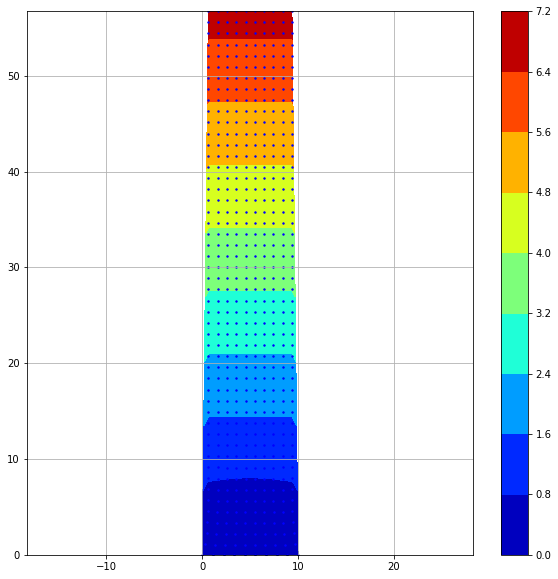

In [132]:
# solving K * Un= R to find displacements of each node
u = np.linalg.solve(K, F)
print(np.max(u))

# plotting the solved displacements
ux = np.reshape(u[0::2], (num_ny, num_nx))  # displacements in X
uy = np.reshape(u[1::2], (num_ny, num_nx))  # displacements in Y
x_new, y_new = [], []
res  = []
for i in range(num_nx):
    for j in range(num_ny):
        x_new.append(i * hx + ux[j,i])
        y_new.append(j * hy + uy[j,i])
        res.append(uy[j,i])
plt.figure(figsize=(10,10))
t = plt.tricontourf(x_new, y_new, res, levels=10, cmap=plt.cm.jet)
plt.scatter(x_new, y_new, marker='o', c='b', s=2)
plt.grid()
plt.colorbar(t)
plt.axis('equal')
plt.show()